In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [2]:
import yfinance as yf

df = yf.download('TSLA', period = '5y', interval = '1d')
df = pd.DataFrame(df.reset_index())
# Double check the result
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-21,46.338001,47.166000,46.216000,46.512001,46.512001,9766000
1,2015-12-22,46.998001,47.310001,45.925999,45.990002,45.990002,9807500
2,2015-12-23,46.436001,46.689999,45.625999,45.939999,45.939999,7775000
3,2015-12-24,46.112000,46.375999,45.655998,46.113998,46.113998,3540000
4,2015-12-28,46.298000,46.396000,45.108002,45.790001,45.790001,9506500


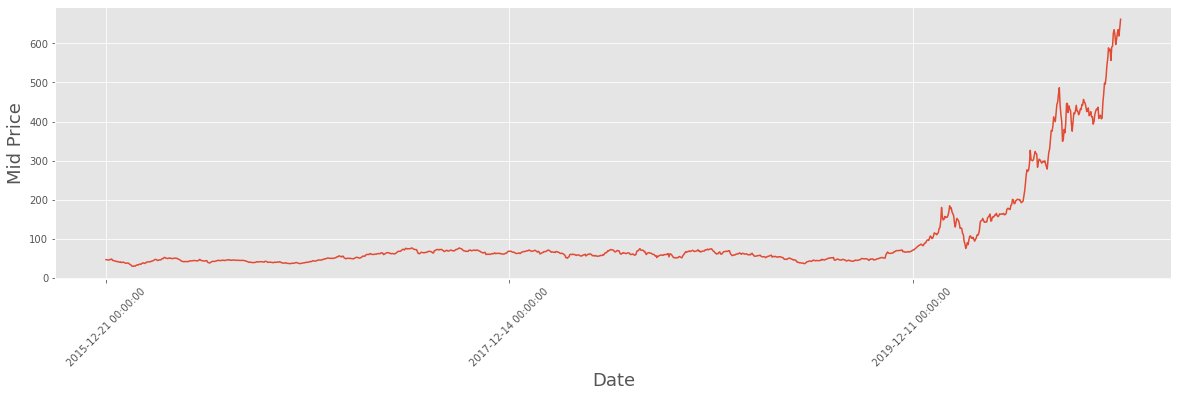

In [3]:
plt.figure(figsize = (20,5))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show();

In [4]:
# First calculate the mid prices from the highest and lowest

fd = pd.DataFrame(df[['High','Low']])

high_prices = fd.loc[:,'High'].to_numpy()
low_prices = fd.loc[:,'Low'].to_numpy()
mid_prices = (high_prices + low_prices) / 2.0

In [5]:
trainTest = int(len(high_prices) * 0.7)
print(len(high_prices), trainTest, (len(high_prices) - trainTest))

train_data = mid_prices[:trainTest]
test_data = mid_prices[trainTest:]

1259 881 378


In [6]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [14]:
# Train the Scaler with training data and smooth data

smoothing_window_size = 10

for di in range(0, 800, smoothing_window_size):
    scaler.fit(train_data[di:di + smoothing_window_size, :])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di + smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di + smoothing_window_size:,:])
train_data[di + smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:]);

In [15]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [17]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(800):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [27]:
window_size = 126
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00201


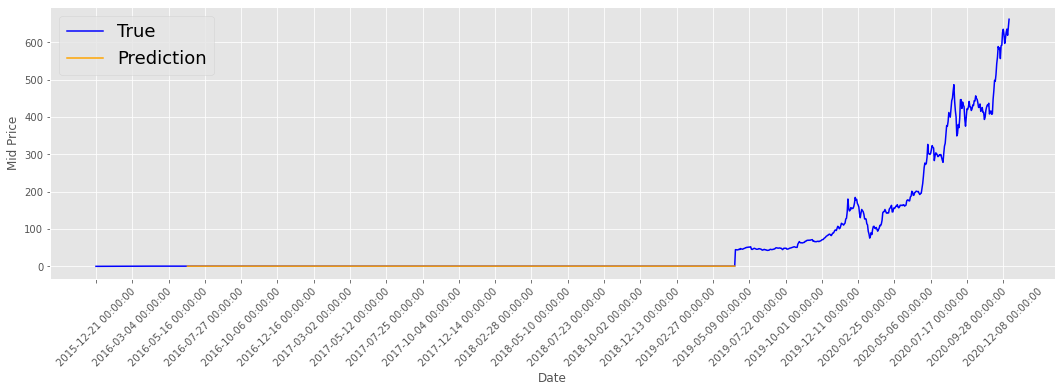

In [28]:
plt.figure(figsize = (18,5))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show();

In [29]:
window_size = 126
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00022


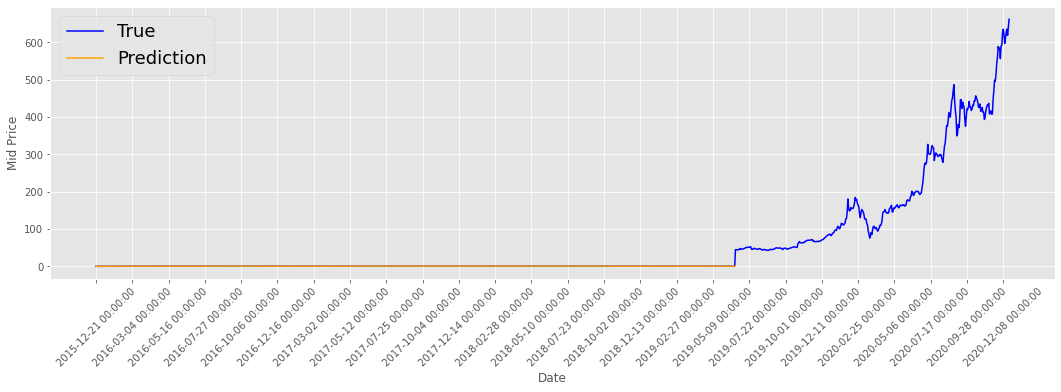

In [31]:
plt.figure(figsize = (18,5))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show();